In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from statsmodels.tsa.exponential_smoothing.ets import ETSModel
from statsmodels.tsa.seasonal import seasonal_decompose

In [2]:
azeri_light = pd.read_excel('data/decomposition/azeri_light.xlsx')
brent = pd.read_excel('data/decomposition/brent.xls')
gdp = pd.read_csv('data/decomposition/gdp.csv')
loan_history = pd.read_csv('data/decomposition/loan_history.csv')


In [3]:
loan_history.rename(columns={'T_DMCREDITSUM':'loan_amount'},inplace=True)
loan_history['T_BDBEGINDATE'] = pd.to_datetime(loan_history['T_BDBEGINDATE'])
loan_history['month'] = loan_history['T_BDBEGINDATE'].dt.to_period('M')
loan_history['quarter'] = loan_history['T_BDBEGINDATE'].dt.to_period('Q')
loan_history['year'] = loan_history['T_BDBEGINDATE'].dt.year
loan_history = loan_history.query("year>=2020").sort_values('T_BDBEGINDATE')
loan_history = loan_history.groupby('quarter',as_index=False)['loan_amount'].sum()

azeri_light['Day'] = pd.to_datetime(azeri_light['Day'])
azeri_light['year']=azeri_light['Day'].dt.year
azeri_light['quarter'] = azeri_light['Day'].dt.to_period('Q')
azeri_light = azeri_light.query("year>=2020").sort_values('Day')

brent['Date'] = pd.to_datetime(brent['Date'])
brent['year'] = brent['Date'].dt.year
brent['quarter'] = brent['Date'].dt.to_period('Q')
brent = brent.query("year>=2020").sort_values('Date')

gdp.rename(columns={'Year':'year'},inplace=True)


azeri_q = azeri_light[['quarter', 'Azeri_Light']].rename(columns={'Azeri_Light': 'amount'})
brent_q = brent[['quarter', 'price']].rename(columns={'price': 'amount'}).copy()
loan_q = loan_history[['quarter', 'loan_amount']].rename(columns={'loan_amount': 'amount'})


In [4]:
# Merge quarterly dataframes: aggregate azeri and brent by quarter (mean), keep loan amounts, then merge
azeri_q_agg = azeri_q.groupby('quarter', as_index=False)['amount'].mean().rename(columns={'amount': 'azeri_avg'})
brent_q_agg = brent_q.groupby('quarter', as_index=False)['amount'].mean().rename(columns={'amount': 'brent_avg'})
loan_q_agg = loan_q.rename(columns={'amount': 'loan_amount'})

merged_quarterly = azeri_q_agg.merge(brent_q_agg, on='quarter', how='outer') \
                              .merge(loan_q_agg, on='quarter', how='outer') \
                              .sort_values('quarter') \
                              .reset_index(drop=True)

merged_quarterly

,quarter,azeri_avg,brent_avg,loan_amount
0,2020Q1,53.074844,50.440000,4.747011e+07
1,2020Q2,32.699016,29.343333,1.658392e+07
2,2020Q3,45.912308,42.963333,5.202839e+07
3,2020Q4,47.316462,44.290000,2.701383e+07
4,2021Q1,63.568889,60.820000,5.351918e+07
5,2021Q2,71.181803,68.833333,7.509509e+07
6,2021Q3,75.709077,73.470000,7.148343e+07
7,2021Q4,81.382500,79.586667,7.906455e+07
8,2022Q1,102.394219,100.296667,7.295831e+07
9,2022Q2,115.335246,113.543333,1.049932e+08


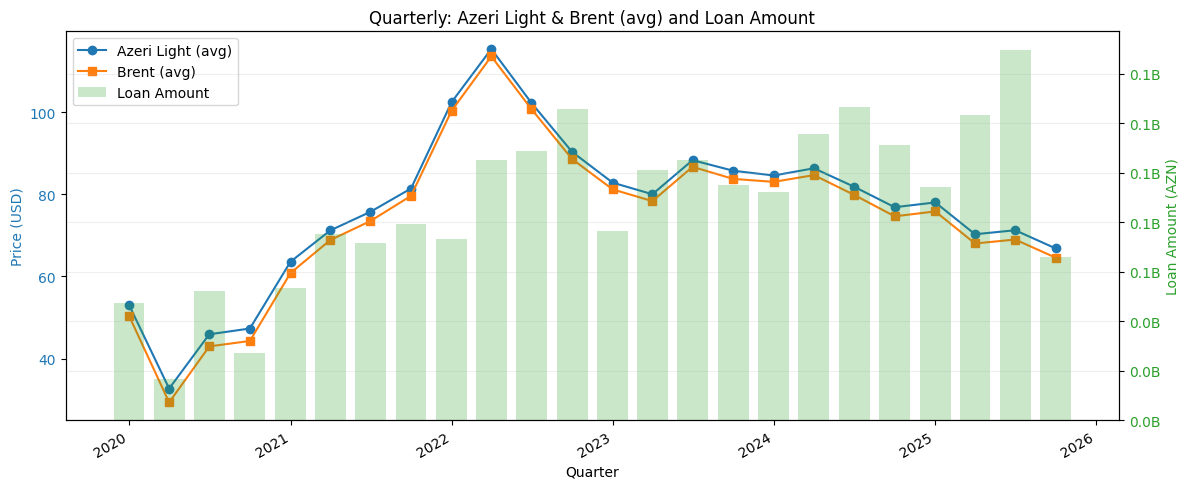

In [5]:
# visualize merged_quarterly: lines for azeri_avg & brent_avg, secondary axis bars for loan_amount
df_plot = merged_quarterly.copy()
df_plot['quarter_start'] = df_plot['quarter'].dt.to_timestamp()

import matplotlib.ticker as ticker

fig, ax1 = plt.subplots(figsize=(12,5))

ax1.plot(df_plot['quarter_start'], df_plot['azeri_avg'],
         marker='o', label='Azeri Light (avg)', color='tab:blue')
ax1.plot(df_plot['quarter_start'], df_plot['brent_avg'],
         marker='s', label='Brent (avg)', color='tab:orange')
ax1.set_xlabel('Quarter')
ax1.set_ylabel('Price (USD)', color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')

ax2 = ax1.twinx()
# show bars only where loan_amount is present
ax2.bar(df_plot['quarter_start'], df_plot['loan_amount'].fillna(0),
        width=70, alpha=0.25, color='tab:green', label='Loan Amount')
ax2.set_ylabel('Loan Amount (AZN)', color='tab:green')
ax2.tick_params(axis='y', labelcolor='tab:green')
ax2.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'{x/1e9:.1f}B'))

# legend, formatting
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2, loc='upper left')

fig.autofmt_xdate()
plt.title('Quarterly: Azeri Light & Brent (avg) and Loan Amount')
plt.grid(alpha=0.2)
plt.tight_layout()
plt.show()

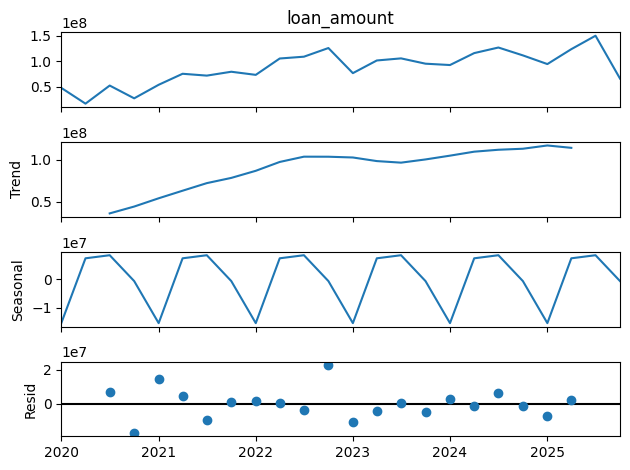

In [9]:
df = merged_quarterly[['quarter','azeri_avg','loan_amount']]
index = df['quarter'].dt.to_timestamp()
data = df.set_index(index)['loan_amount']
decomposition = seasonal_decompose(data, model='additive', period=4)
fig = decomposition.plot()


In [10]:
model = ETSModel(data, error='add', trend='add', seasonal='add', seasonal_periods=4)
fit = model.fit()
fit.summary()

c:\Users\iasamadov\Desktop\loan_sales_prediction\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                  ETS Results                                  
===============================================================================
Dep. Variable:            loan_amount   No. Observations:                    24
Model:                       ETS(AAA)   Log Likelihood                 -438.995
Date:                Sat, 15 Nov 2025   AIC                             897.989
Time:                        15:26:40   BIC                             909.770
Sample:                    01-01-2020   HQIC                            901.114
                         - 10-01-2025   Scale               452134562577519.500
Covariance Type:               approx                                          
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
smoothing_level        0.1363      0.178      0.767      0.443      -0.212       0.485
smoothing_trend        0.0607      0.026      2.296      0.022       0.009       0.112
smoothing_seasonal  8.637e-05      0.216      0.000      1.000      -0.422       0.423
initial_level       3.054e+07   1.71e-09   1.79e+16      0.000    3.05e+07    3.05e+07
initial_trend       7.903e+06    2.4e-08    3.3e+14      0.000     7.9e+06     7.9e+06
initial_seasonal.0 -1.327e+07   5.39e-09  -2.46e+15      0.000   -1.33e+07   -1.33e+07
initial_seasonal.1  7.226e+06   5.82e-09   1.24e+15      0.000    7.23e+06    7.23e+06
initial_seasonal.2  7.212e+06   3.82e-09   1.89e+15      0.000    7.21e+06    7.21e+06
initial_seasonal.3          0   9.02e-09          0      1.000   -1.77e-08    1.77e-08
===================================================================================
Ljung-Box (Q):                        0.91   Jarque-Bera (JB):                 0.28
Prob(Q):                              0.92   Prob(JB):                         0.87
Heteroskedasticity (H):               1.57   Skew:                             0.05
Prob(H) (two-sided):                  0.54   Kurtosis:                         2.48
===================================================================================

Warnings:
[1] Covariance matrix calculated using numerical (complex-step) differentiation.
[2] Covariance matrix is singular or near-singular, with condition number 1.38e+32. Standard errors may be unstable.
"""

C:\Users\iasamadov\AppData\Local\Temp\ipykernel_28544\2038264577.py:2: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  forecast_index = pd.date_range(start=data.index[-1] + pd.offsets.QuarterBegin(), periods=4, freq='Q')


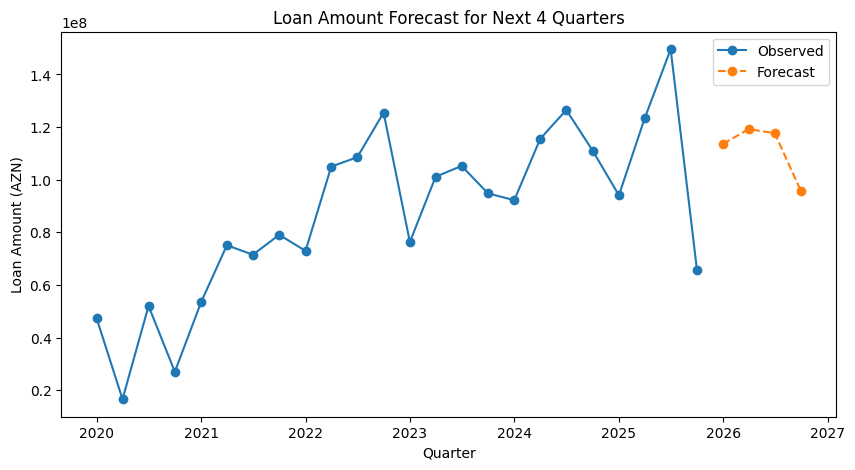

In [12]:
forecast = fit.forecast(steps=4)
forecast_index = pd.date_range(start=data.index[-1] + pd.offsets.QuarterBegin(), periods=4, freq='Q')
forecast_series = pd.Series(forecast.values, index=forecast_index)
fig, ax = plt.subplots(figsize=(10,5))
ax.plot(data.index, data, label='Observed', marker='o')
ax.plot(forecast_series.index, forecast_series, label='Forecast', marker='o', linestyle='--')
ax.set_xlabel('Quarter')
ax.set_ylabel('Loan Amount (AZN)')
ax.set_title('Loan Amount Forecast for Next 4 Quarters')
ax.legend()
plt.show()